In [1]:
# ======================================
# IG Virality Analysis - Jupyter Notebook
# ======================================

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# Optional ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set(style="whitegrid")

# --------------------------
# File Paths
# --------------------------
EXCEL_PATH_ALL = r"C:\Users\jiang\Downloads\Capstone\combine_ig_data.xlsx"
EXCEL_PATH_CATS = r"C:\Users\jiang\Downloads\Capstone\catsonly_combined_ig_data.xlsx"


# --------------------------
# Load Data
# --------------------------
df_all = pd.read_excel(EXCEL_PATH_ALL, engine="openpyxl", dtype=str)
df_cats = pd.read_excel(EXCEL_PATH_CATS, engine="openpyxl", dtype=str)

print("All data shape:", df_all.shape)
print("Cat-only data shape:", df_cats.shape)

All data shape: (1046, 10)
Cat-only data shape: (495, 10)


In [2]:
# --- All Posts ---
df_all["Date_raw"] = df_all["Date"]
df_all["Date_parsed"] = pd.to_datetime(df_all["Date"], errors="coerce", utc=True)
df_all["Date_standard"] = df_all["Date_parsed"].dt.strftime("%Y-%m-%d")

df_all["Video Duration"] = pd.to_numeric(df_all["Video Duration"], errors="coerce")
bins = [0, 15, 30, 60, 120, np.inf]
labels = ["<15s", "15-30s", "30-60s", "60-120s", ">120s"]
df_all["DurationBin"] = pd.cut(df_all["Video Duration"], bins=bins, labels=labels)

df_all["Likes"] = pd.to_numeric(df_all["Likes"], errors="coerce").fillna(0)
df_all["Comments"] = pd.to_numeric(df_all["Comments"], errors="coerce").fillna(0)
df_all["Views"] = pd.to_numeric(df_all["Views"], errors="coerce")

df_all["like_view_ratio"] = np.where(df_all["Views"]>0, df_all["Likes"]/df_all["Views"], np.nan)
df_all["comment_view_ratio"] = np.where(df_all["Views"]>0, df_all["Comments"]/df_all["Views"], np.nan)
df_all["engagement_per_view"] = np.where(
    df_all["Views"] > 0,
    (df_all["Likes"] + df_all["Comments"]) / df_all["Views"],
    np.nan
)

print("📊 Average Likes & Comments per Post Type (All Posts)")
print(df_all.groupby("Post Type")[["Likes", "Comments"]].mean().round(2))

print("\n📊 Average Engagement Rate per Post Type (All Posts)")
print(df_all.groupby("Post Type")["engagement_per_view"].mean().round(4))

df_all["caption_length"] = df_all["Captions"].apply(lambda x: len(str(x).split()))


# --- Cat Posts ---
df_cats["Date_raw"] = df_cats["Date"]
df_cats["Date_parsed"] = pd.to_datetime(df_cats["Date"], errors="coerce", utc=True)
df_cats["Date_standard"] = df_cats["Date_parsed"].dt.strftime("%Y-%m-%d")

df_cats["Video Duration"] = pd.to_numeric(df_cats["Video Duration"], errors="coerce")
df_cats["DurationBin"] = pd.cut(df_cats["Video Duration"], bins=bins, labels=labels)

df_cats["Likes"] = pd.to_numeric(df_cats["Likes"], errors="coerce").fillna(0)
df_cats["Comments"] = pd.to_numeric(df_cats["Comments"], errors="coerce").fillna(0)
df_cats["Views"] = pd.to_numeric(df_cats["Views"], errors="coerce")

df_cats["like_view_ratio"] = np.where(df_cats["Views"]>0, df_cats["Likes"]/df_cats["Views"], np.nan)
df_cats["comment_view_ratio"] = np.where(df_cats["Views"]>0, df_cats["Comments"]/df_cats["Views"], np.nan)
df_cats["engagement_per_view"] = np.where(
    df_cats["Views"] > 0,
    (df_cats["Likes"] + df_cats["Comments"]) / df_cats["Views"],
    np.nan
)

print("\n📊 Average Likes & Comments per Post Type (Cat Posts)")
print(df_cats.groupby("Post Type")[["Likes", "Comments"]].mean().round(2))

print("\n📊 Average Engagement Rate per Post Type (Cat Posts)")
print(df_cats.groupby("Post Type")["engagement_per_view"].mean().round(4))

df_cats["caption_length"] = df_cats["Captions"].apply(lambda x: len(str(x).split()))


📊 Average Likes & Comments per Post Type (All Posts)
                Likes  Comments
Post Type                      
Image      1593106.47  15197.29
Sidecar    1668102.08  10017.18
Video       423221.85   5997.19

📊 Average Engagement Rate per Post Type (All Posts)
Post Type
Image         NaN
Sidecar       NaN
Video      0.0442
Name: engagement_per_view, dtype: float64

📊 Average Likes & Comments per Post Type (Cat Posts)
              Likes  Comments
Post Type                    
Image      10418.09     55.82
Sidecar    28588.34    205.32
Video      55852.34    699.76

📊 Average Engagement Rate per Post Type (Cat Posts)
Post Type
Image         NaN
Sidecar       NaN
Video      0.0554
Name: engagement_per_view, dtype: float64


In [3]:
# ----- All posts -----
print("📊 Average Views by Post Type (All Posts)")
print(df_all.groupby("Post Type")["Views"].mean())

print("\n📊 Median Views by DurationBin (All Posts)")
print(df_all.groupby("DurationBin")["Views"].median())

# ----- Cat posts only -----
print("\n📊 Average Views by Post Type (Cat Posts)")
print(df_cats.groupby("Post Type")["Views"].mean())

print("\n📊 Median Views by DurationBin (Cat Posts)")
print(df_cats.groupby("DurationBin")["Views"].median())


📊 Average Views by Post Type (All Posts)
Post Type
Image               NaN
Sidecar             NaN
Video      1.134260e+07
Name: Views, dtype: float64

📊 Median Views by DurationBin (All Posts)
DurationBin
<15s        199493.0
15-30s     3223797.0
30-60s     1669183.5
60-120s    1980005.0
>120s      6825947.0
Name: Views, dtype: float64

📊 Average Views by Post Type (Cat Posts)
Post Type
Image                NaN
Sidecar              NaN
Video      939588.966165
Name: Views, dtype: float64

📊 Median Views by DurationBin (Cat Posts)
DurationBin
<15s        164851.0
15-30s      331427.0
30-60s      378795.5
60-120s    1095222.5
>120s       794143.0
Name: Views, dtype: float64


In [6]:
#display top hashtags

from IPython.display import display, Markdown

# ----- All posts -----
hashtags_all = [tag for tags in df_all["Captions"].dropna().str.findall(r"#\w+") for tag in tags]
top_hashtags_all = pd.Series(hashtags_all).value_counts().head(20)

display(Markdown("### 🏷️ Top 20 Hashtags (All Posts)"))
for i, tag in enumerate(top_hashtags_all.index, 1):
    display(Markdown(f"**{i}.** `{tag}`"))

# ----- Cat posts only -----
hashtags_cats = [tag for tags in df_cats["Captions"].dropna().str.findall(r"#\w+") for tag in tags]
top_hashtags_cats = pd.Series(hashtags_cats).value_counts().head(20)

display(Markdown("### 🏷️ Top 20 Hashtags (Cat Posts)"))
for i, tag in enumerate(top_hashtags_cats.index, 1):
    display(Markdown(f"**{i}.** `{tag}`"))


### 🏷️ Top 20 Hashtags (All Posts)

**1.** `#cat`

**2.** `#cats`

**3.** `#catsofinstagram`

**4.** `#instagood`

**5.** `#instadaily`

**6.** `#cute`

**7.** `#love`

**8.** `#thatlittlepuff`

**9.** `#catsofig`

**10.** `#reels`

**11.** `#catloversclub`

**12.** `#catsofinsta`

**13.** `#mrmilothechonk`

**14.** `#milothechonk`

**15.** `#reelsig`

**16.** `#viral`

**17.** `#comedy`

**18.** `#lol`

**19.** `#reelsinstagram`

**20.** `#chonk`

### 🏷️ Top 20 Hashtags (Cat Posts)

**1.** `#cat`

**2.** `#cats`

**3.** `#catsofinstagram`

**4.** `#instagood`

**5.** `#instadaily`

**6.** `#cute`

**7.** `#love`

**8.** `#thatlittlepuff`

**9.** `#catsofig`

**10.** `#catloversclub`

**11.** `#reels`

**12.** `#catsofinsta`

**13.** `#mrmilothechonk`

**14.** `#milothechonk`

**15.** `#reelsig`

**16.** `#viral`

**17.** `#comedy`

**18.** `#lol`

**19.** `#reelsinstagram`

**20.** `#explore`

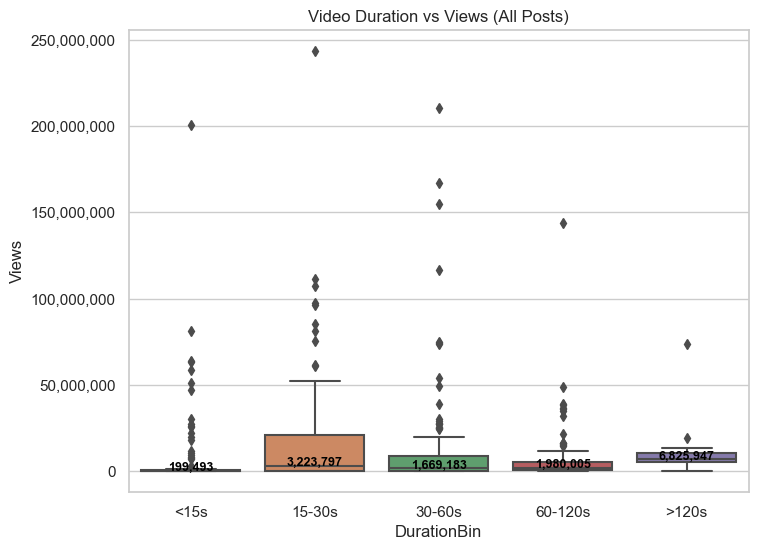

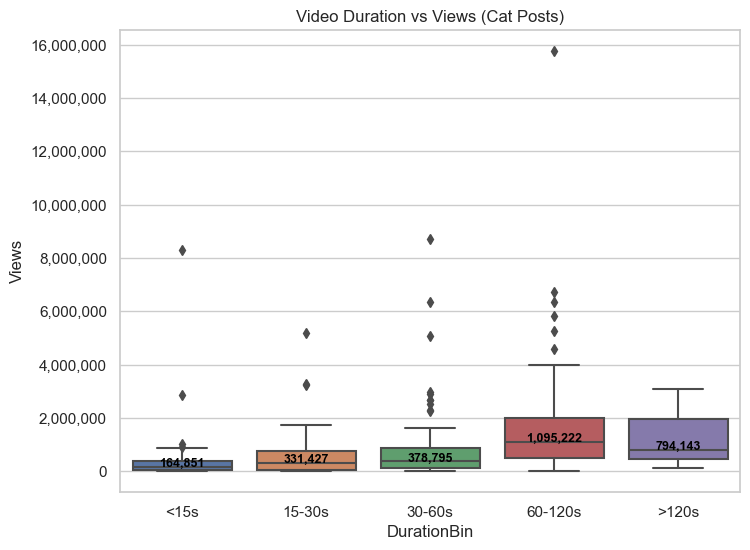

In [19]:
import matplotlib.ticker as ticker

def plot_duration_vs_views(df, title):
    plt.figure(figsize=(8,6))
    ax = sns.boxplot(x="DurationBin", y="Views", data=df, showmeans=False)

    # Annotate median values
    medians = df.groupby("DurationBin")["Views"].median()
    for tick, label in enumerate(ax.get_xticklabels()):
        duration = label.get_text()
        median_val = medians.loc[duration]
        ax.text(tick, median_val, f"{int(median_val):,}", 
                horizontalalignment="center", color="black", weight="bold", fontsize=9)

    ax.set_title(title)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    plt.show()

# ----- All posts -----
plot_duration_vs_views(df_all, "Video Duration vs Views (All Posts)")

# ----- Cat posts only -----
plot_duration_vs_views(df_cats, "Video Duration vs Views (Cat Posts)")


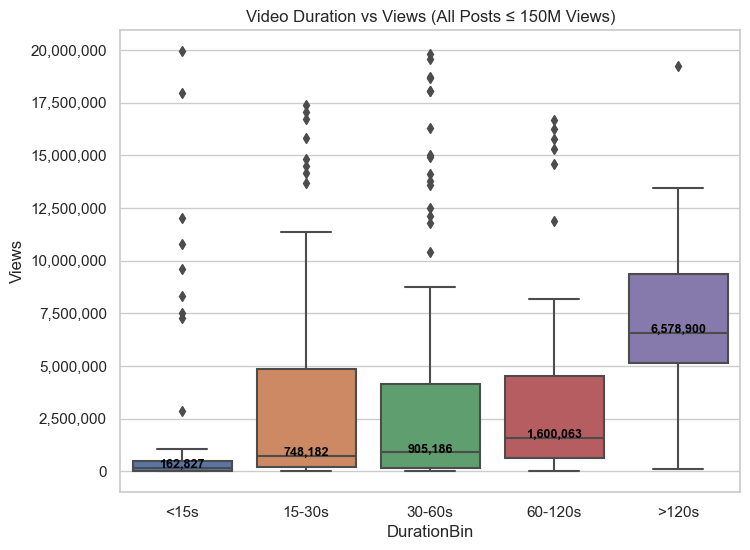

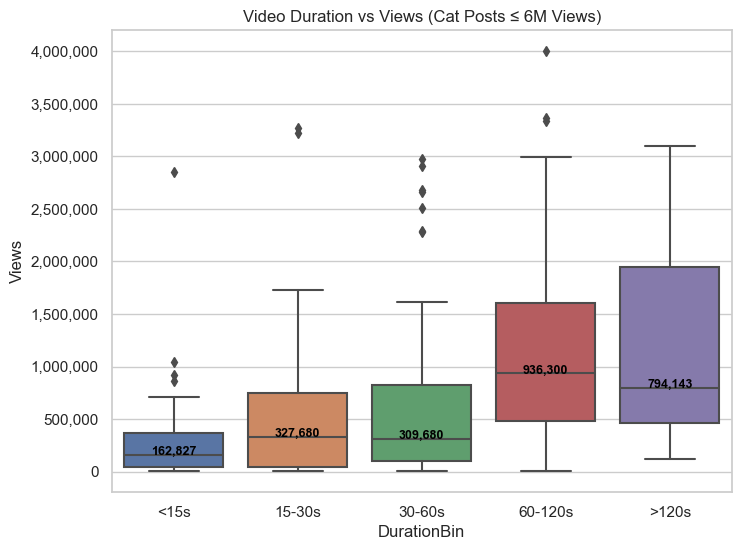

In [20]:
# Apply view limits
df_all_limited = df_all[df_all["Views"] <= 20_000_000]
df_cats_limited = df_cats[df_cats["Views"] <= 4_000_000]

# Plot with filtered data
plot_duration_vs_views(df_all_limited, "Video Duration vs Views (All Posts ≤ 150M Views)")
plot_duration_vs_views(df_cats_limited, "Video Duration vs Views (Cat Posts ≤ 6M Views)")
